In [93]:
!pip install visdom

In [94]:
import numpy as np
import cv2 as cv2
import matplotlib.pyplot as plt
import h5py
from tqdm import tqdm
import cv2

In [95]:
import os

In [96]:
parent_path = "drive/MyDrive/M202A/"

path_to_dataset = parent_path+"transcg/"

config={"path":path_to_dataset,"all_files":[]}
def extract_files(config):
  path = config["path"]
  all_files = config["all_files"]
  for (path,directory,files) in tqdm(os.walk(path)):
    if(files!=[]):
      files= [path+"//"+i for i in files]
      if((path+"//rgb2.png" in files) and(path+"//depth2-gt.png" in files) and (path+"//depth2-gt-mask.png") and (path+"//depth2.png" in files)):
          all_files.append(files)


extract_files(config)

1921it [00:01, 1181.70it/s]


In [97]:
from PIL import Image

In [98]:


def load_files(config):
  filepaths = config["all_files"]
  length = len(filepaths)
  batchsize = length//6
  indices = np.random.randint(low=0,high=length,size=batchsize)
  color = np.zeros((batchsize,1280,720,3)).astype(np.uint8)
  rawdepth = np.zeros((batchsize,1280,720)).astype(np.float32)
  groundtruth = np.zeros_like(rawdepth).astype(np.float32)
  depthmasks = np.zeros_like(rawdepth).astype(np.uint8)
  pbar = tqdm(total=batchsize)
  count = 0
  for idx in indices:
    files = filepaths[idx]
    for f in files:
      if("rgb2.png" in f):
        color[count,...] = np.asarray(Image.open(f)).transpose(1,0,2)
      elif("depth2-gt-mask.png" in f):
        depthmasks[count,...] = np.asarray(Image.open(f)).astype(np.uint8).T
      elif("depth2-gt.png" in f):
        groundtruth[count,...] = 2.5e-4*np.asarray(Image.open(f)).astype(np.float32).T
      elif("depth2.png" in f):
        rawdepth[count,...] = 2.5e-4*np.asarray(Image.open(f)).astype(np.float32).T
    pbar.update(1)
    count+=1
  config["color"] = color
  config["depth"] = groundtruth
  config["rawDepth"] = rawdepth
  config["validmasks"]= depthmasks

load_files(config)


100%|██████████| 318/318 [05:54<00:00,  1.12s/it]


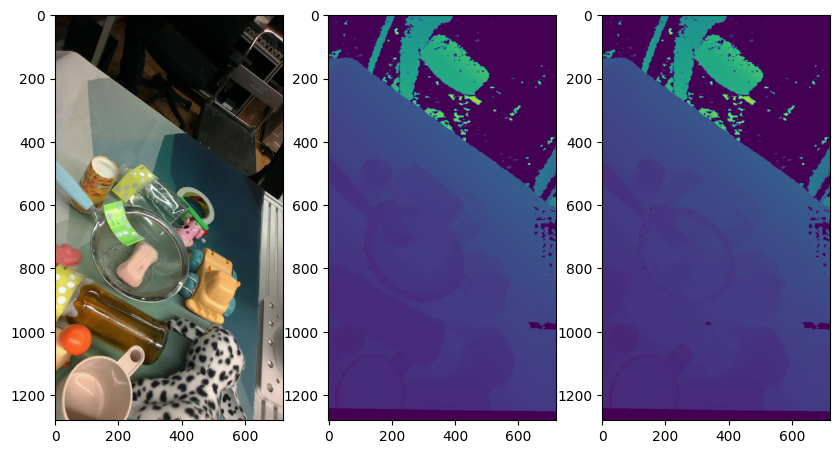

In [99]:
%matplotlib inline
fig,axs = plt.subplots(1,3,figsize=(10,10))
color = config["color"]
axs[0].imshow(color[0].astype(np.uint8))

depth = config["depth"]
axs[1].imshow(depth[0])
rawdepth = config["rawDepth"]
axs[2].imshow(rawdepth[0])



In [100]:
def anisodiff(img,niter=1,kappa=50,gamma=0.1,step=(1.,1.),sigma=0, option=1,ploton=False):
	"""
	Anisotropic diffusion.

	Usage:
	imgout = anisodiff(im, niter, kappa, gamma, option)

	Arguments:
	        img    - input image
	        niter  - number of iterations
	        kappa  - conduction coefficient 20-100 ?
	        gamma  - max value of .25 for stability
	        step   - tuple, the distance between adjacent pixels in (y,x)
	        option - 1 Perona Malik diffusion equation No 1
	                 2 Perona Malik diffusion equation No 2
	        ploton - if True, the image will be plotted on every iteration

	Returns:
	        imgout   - diffused image.

	kappa controls conduction as a function of gradient.  If kappa is low
	small intensity gradients are able to block conduction and hence diffusion
	across step edges.  A large value reduces the influence of intensity
	gradients on conduction.

	gamma controls speed of diffusion (you usually want it at a maximum of
	0.25)

	step is used to scale the gradients in case the spacing between adjacent
	pixels differs in the x and y axes

	Diffusion equation 1 favours high contrast edges over low contrast ones.
	Diffusion equation 2 favours wide regions over smaller ones.

	Reference:
	P. Perona and J. Malik.
	Scale-space and edge detection using ansotropic diffusion.
	IEEE Transactions on Pattern Analysis and Machine Intelligence,
	12(7):629-639, July 1990.

	Original MATLAB code by Peter Kovesi
	School of Computer Science & Software Engineering
	The University of Western Australia
	pk @ csse uwa edu au
	<http://www.csse.uwa.edu.au>

	Translated to Python and optimised by Alistair Muldal
	Department of Pharmacology
	University of Oxford
	<alistair.muldal@pharm.ox.ac.uk>

	June 2000  original version.
	March 2002 corrected diffusion eqn No 2.
	July 2012 translated to Python
	"""

	# ...you could always diffuse each color channel independently if you
	# really want
	if img.ndim == 3:
		warnings.warn("Only grayscale images allowed, converting to 2D matrix")
		img = img.mean(2)

	# initialize output array
	img = img.astype('float32')
	imgout = img.copy()

	# initialize some internal variables
	deltaS = np.zeros_like(imgout)
	deltaE = deltaS.copy()
	NS = deltaS.copy()
	EW = deltaS.copy()
	gS = np.ones_like(imgout)
	gE = gS.copy()

	# create the plot figure, if requested
	if ploton:
		import pylab as pl
		from time import sleep

		fig = pl.figure(figsize=(20,5.5),num="Anisotropic diffusion")
		ax1,ax2 = fig.add_subplot(1,2,1),fig.add_subplot(1,2,2)

		ax1.imshow(img,interpolation='nearest')
		ih = ax2.imshow(imgout,interpolation='nearest',animated=True)
		ax1.set_title("Original image")
		ax2.set_title("Iteration 0")

		fig.canvas.draw()

	for ii in np.arange(1,niter):

		# calculate the diffs
		deltaS[:-1,: ] = np.diff(imgout,axis=0)
		deltaE[: ,:-1] = np.diff(imgout,axis=1)

		if 0<sigma:
			deltaSf=flt.gaussian_filter(deltaS,sigma);
			deltaEf=flt.gaussian_filter(deltaE,sigma);
		else:
			deltaSf=deltaS;
			deltaEf=deltaE;

		# conduction gradients (only need to compute one per dim!)
		if option == 1:
			gS = np.exp(-(deltaSf/kappa)**2.)/step[0]
			gE = np.exp(-(deltaEf/kappa)**2.)/step[1]
		elif option == 2:
			gS = 1./(1.+(deltaSf/kappa)**2.)/step[0]
			gE = 1./(1.+(deltaEf/kappa)**2.)/step[1]

		# update matrices
		E = gE*deltaE
		S = gS*deltaS

		# subtract a copy that has been shifted 'North/West' by one
		# pixel. don't as questions. just do it. trust me.
		NS[:] = S
		EW[:] = E
		NS[1:,:] -= S[:-1,:]
		EW[:,1:] -= E[:,:-1]

		# update the image
		imgout += gamma*(NS+EW)

		if ploton:
			iterstring = "Iteration %i" %(ii+1)
			ih.set_data(imgout)
			ax2.set_title(iterstring)
			fig.canvas.draw()
			# sleep(0.01)

	return imgout



In [170]:
random_indice = np.random.randint(0,len(rawdepth),size=1)
import warnings

In [171]:
def center_crop(image):
  center = image.shape
  x = center[2]//2
  y = center[1]//2

  crop_img = image[:,y-240:y+240,x-320:x+320]
  return crop_img

In [172]:
center_crop(rawdepth[random_indice]).shape

(1, 480, 640)

In [173]:
mask = depth[random_indice]>0


denoised_depth_bilateral = cv2.bilateralFilter(center_crop(rawdepth[random_indice]).astype(np.float32).squeeze(),5,150,150)


denoised_depth_diffusion = anisodiff(center_crop(rawdepth[random_indice]).astype(np.float32).squeeze(),niter=200)



In [174]:
!git clone https://github.com/VCL3D/DeepDepthDenoising

fatal: destination path 'DeepDepthDenoising' already exists and is not an empty directory.


In [175]:
import sys
sys.path.insert(1, 'DeepDepthDenoising/')

In [176]:
import models
import utils
import importers
from supervision import *
from exporters import *
from importers import *

In [177]:
dddpath = "drive/MyDrive/M202A/ddd"

In [178]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [179]:
from torchvision.transforms import v2
transforms = v2.Compose([v2.CenterCrop((480,640))])

In [180]:
rawdepth[0].shape

(1280, 720)

In [181]:
model_params = {
        'width': 720,
        'height': 1280,
        'ndf': 8,
        'dilation': 1,
        'norm_type': "elu",
        'upsample_type': "nearest"
    }



model = models.get_model(model_params).to(device)
utils.init.initialize_weights(model,dddpath)
uv_grid_t =  create_image_domain_grid(model_params['width'], model_params['height'])

rawD = torch.tensor(rawdepth[random_indice],dtype=torch.float).to(device)

rawD = rawD.reshape(1,1,1280,720)
mask,_ = get_mask(rawD)
predicted_depth,_ = model(rawD,mask)
masked_predicted_depth = predicted_depth*mask
denoised_depth_sota = masked_predicted_depth.detach().to("cpu").numpy()


In [182]:
import yaml
with open('drive/MyDrive/M202A/'+'config.yaml', 'r') as file:
    model_configs = yaml.safe_load(file)
model_configs['model']['channels']=1
model_configs['model']['base filters']=16

In [183]:
from model import *

In [184]:
class Resnet_UNet(nn.Module):
  """
  Residual-Dense U-net for image denoising.
  """
  def __init__(self,**kwargs):
      super().__init__()
      channels = kwargs['channels']
      filters_0 = kwargs['base filters']
      filters_1 = 2 * filters_0
      filters_2 = 4 * filters_0
      filters_3 = 8 * filters_0

      # Encoder:
      # Level 0:
      self.drop = nn.Dropout(p=0.5)
      self.input_block = InputBlock(4, filters_0)
      self.block_0_0 = DenoisingBlock(filters_0, filters_0 // 2, filters_0)
      self.block_0_1 = DenoisingBlock(filters_0, filters_0 // 2, filters_0)
      self.down_0 = DownsampleBlock(filters_0, filters_1)

      # Level 1:
      self.block_1_0 = DenoisingBlock(filters_1, filters_1 // 2, filters_1)
      self.block_1_1 = DenoisingBlock(filters_1, filters_1 // 2, filters_1)
      self.down_1 = DownsampleBlock(filters_1, filters_2)

      # Level 2:
      self.block_2_0 = DenoisingBlock(filters_2, filters_2 // 2, filters_2)
      self.block_2_1 = DenoisingBlock(filters_2, filters_2 // 2, filters_2)
      self.down_2 = DownsampleBlock(filters_2, filters_3)

      # Level 3 (Bottleneck)
      self.block_3_0 = DenoisingBlock(filters_3, filters_3 // 2, filters_3)
      self.block_3_1 = DenoisingBlock(filters_3, filters_3 // 2, filters_3)

      # Decoder
      # Level 2:
      self.up_2 = UpsampleBlock(filters_3, filters_2, filters_2)
      self.block_2_2 = DenoisingBlock(filters_2, filters_2 // 2, filters_2)
      self.block_2_3 = DenoisingBlock(filters_2, filters_2 // 2, filters_2)

      # Level 1:
      self.up_1 = UpsampleBlock(filters_2, filters_1, filters_1)
      self.block_1_2 = DenoisingBlock(filters_1, filters_1 // 2, filters_1)
      self.block_1_3 = DenoisingBlock(filters_1, filters_1 // 2, filters_1)

      # Level 0:
      self.up_0 = UpsampleBlock(filters_1, filters_0, filters_0)
      self.block_0_2 = DenoisingBlock(filters_0, filters_0 // 2, filters_0)
      self.block_0_3 = DenoisingBlock(filters_0, filters_0 // 2, filters_0)

      self.output_block = OutputBlock(filters_0, channels)


  def forward(self, inputs):
      inputs = self.drop(inputs)
      out_0 = self.input_block(inputs)    # Level 0
      out_0 = self.block_0_0(out_0)
      out_0 = self.block_0_1(out_0)

      out_1 = self.down_0(out_0)          # Level 1
      out_1 = self.block_1_0(out_1)
      out_1 = self.block_1_1(out_1)

      out_2 = self.down_1(out_1)          # Level 2
      out_2 = self.block_2_0(out_2)
      out_2 = self.block_2_1(out_2)

      out_3 = self.down_2(out_2)          # Level 3 (Bottleneck)

      out_3 = self.block_3_0(out_3)
      out_3 = self.block_3_1(out_3)



      out_4 = self.up_2([out_3, out_2])   # Level 2
      out_4 = self.block_2_2(out_4)
      out_4 = self.block_2_3(out_4)

      out_5 = self.up_1([out_4, out_1])   # Level 1
      out_5 = self.block_1_2(out_5)
      out_5 = self.block_1_3(out_5)

      out_6 = self.up_0([out_5, out_0])   # Level 0
      out_6 = self.block_0_2(out_6)
      out_6 = self.block_0_3(out_6)

      return self.output_block(out_6)


In [185]:
MSE_Model = Resnet_UNet(**model_configs['model'])
MSE_Model_sparse = Resnet_UNet(**model_configs['model'])


MSE_Model.load_state_dict(torch.load("drive/MyDrive/M202A/MSE_Model.pth"))
MSE_Model_sparse.load_state_dict(torch.load("drive/MyDrive/M202A/Autoencoder_MSE.pth"))

MSE_Model.to(device)
MSE_Model_sparse.to(device)

Resnet_UNet(
  (drop): Dropout(p=0.5, inplace=False)
  (input_block): InputBlock(
    (conv_1): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (actv_1): PReLU(num_parameters=16)
    (actv_2): PReLU(num_parameters=16)
  )
  (block_0_0): DenoisingBlock(
    (conv_0): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_1): Conv2d(24, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_2): Conv2d(32, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_3): Conv2d(40, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (actv_0): PReLU(num_parameters=8)
    (actv_1): PReLU(num_parameters=8)
    (actv_2): PReLU(num_parameters=8)
    (actv_3): PReLU(num_parameters=16)
  )
  (block_0_1): DenoisingBlock(
    (conv_0): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_1): Conv2d(24, 8, kernel_size=(3, 3), stride=(1, 1),

In [186]:
from torchvision.transforms import v2
transforms = v2.Compose([v2.CenterCrop((480,640))])

In [187]:
my_raw_d = transforms(rawD)

In [188]:
denoised_depth_sota = denoised_depth_sota.reshape(1,1280,720)
denoised_depth_sota = center_crop(denoised_depth_sota)

In [189]:
color_tensor = torch.tensor(color[random_indice],device=device,dtype=torch.float32).permute(0,3,1,2)/255
color_tensor = transforms(color_tensor)
stacked = torch.hstack((my_raw_d,color_tensor))

n_estimate_mse = MSE_Model(stacked)
n_estimate_mse_sparse = MSE_Model_sparse(stacked)

denoised_estimate_mse = my_raw_d-n_estimate_mse
denoised_estimate_mse_sparse = my_raw_d-n_estimate_mse_sparse

denoised_estimate_mse = denoised_estimate_mse.detach().to("cpu").numpy()
denoised_estimate_mse_sparse = denoised_estimate_mse_sparse.detach().to("cpu").numpy()




Text(0.5, 1.0, 'Bilateral Filter')

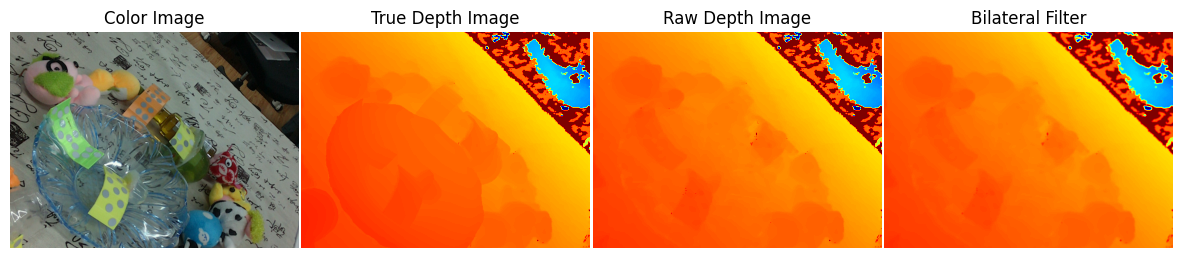

In [196]:
fig,axs = plt.subplots(1,4,gridspec_kw = {'wspace':1e-2, 'hspace':0},figsize=(15,15))
axs[0].imshow(center_crop(color[random_indice]).squeeze().astype(np.uint8))
axs[0].axis("off")
axs[0].set_title("Color Image")
axs[1].imshow(center_crop(depth[random_indice]).squeeze(),cmap='jet_r')
axs[1].axis("off")
axs[1].set_title("True Depth Image")
axs[2].imshow(center_crop(rawdepth[random_indice]).squeeze(),cmap='jet_r')
axs[2].axis("off")
axs[2].set_title("Raw Depth Image")
axs[3].imshow(denoised_depth_bilateral,cmap='jet_r')
axs[3].axis("off")
axs[3].set_title("Bilateral Filter")



In [191]:
denoised_depth_sota.shape

(1, 480, 640)

Text(0.5, 1.0, 'MSE Loss with Group Sparsity')

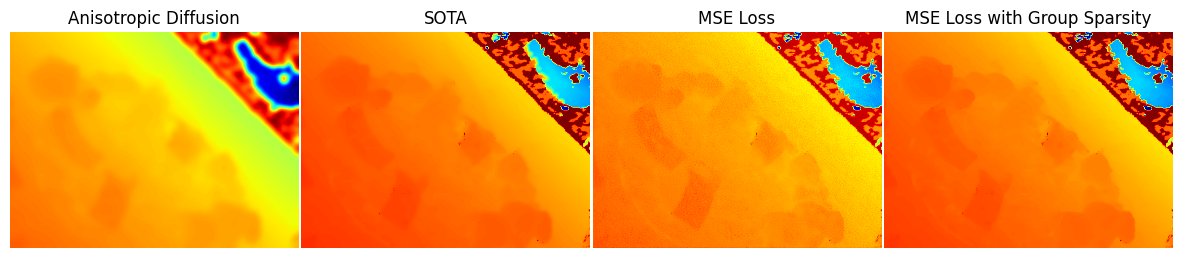

In [195]:
fig,axs = plt.subplots(1,4,gridspec_kw = {'wspace':1e-2, 'hspace':0},figsize=(15,15))
axs[0].imshow(denoised_depth_diffusion,cmap='jet_r')
axs[0].axis("off")
axs[0].set_title("Anisotropic Diffusion")
axs[1].imshow(denoised_depth_sota.squeeze(),cmap='jet_r')
axs[1].axis("off")
axs[1].set_title("SOTA")
axs[2].imshow(denoised_estimate_mse.squeeze(),cmap='jet_r')
axs[2].axis("off")
axs[2].set_title("MSE Loss")
axs[3].imshow(denoised_estimate_mse_sparse.squeeze(),cmap='jet_r')
axs[3].axis("off")
axs[3].set_title("MSE Loss with Group Sparsity")